##### Imports and files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import sklearn
from keras import layers
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from IPython.display import display, Markdown

2023-12-16 14:24:11.065403: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 14:24:11.193655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 14:24:11.193734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 14:24:11.212851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 14:24:11.261304: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 14:24:11.263056: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
dists = pd.read_csv("data/atlas_open_data_files/distributions.csv")
dist_changes = pd.read_csv("data/atlas_open_data_files/distribution_changes.csv")
grid_coords = pd.read_csv(
    "data/atlas_open_data_files/grid_square_coordinates_lookup.csv"
)
pct_bench_species = pd.read_csv(
    "data/atlas_open_data_files/percent_benchmark_species_detected.csv"
)
species_lookup = pd.read_csv(
    "data/atlas_open_data_files/species_lookup_nocase.csv", encoding="ISO-8859-1"
)
conservation_status = pd.read_csv("data/conservation/conservation_status_final.csv")

#### Misc stuff

In [5]:
# These are the top 10 birds which were spotted most in the Big Garden
# Birdwatch (2023) https://www.rspb.org.uk/whats-happening/big-garden-birdwatch
HOUSE_SPARROW = 459
BLUE_TIT = 436
STARLING = 457
WOODPIDGEON = 270
BLACKBIRD = 371
ROBIN = 345
GOLDFINCH = 471
GREAT_TIT = 437
MAGPIE = 450
LONG_TAILED_TIT = 431

# Ideas
- **Feed data in to NN which predicts whether a bird will be on the latest Red List or not**
    - For birds that are in both 1970-1990 and 1990-2010, feed a NN the average stable, loss and gain over all grid squares, for both intervals

# Predicting conservation status using citizen science bird atlases
- Do the BTO Birds of Conservation Concern lists reflect the change in bird distributions found in citizen science data?

[Classifications are from the BTO birds of conservation concern](https://www.bto.org/our-science/publications/birds-conservation-concern)

## Data preprocessing

### Conservation status
- Got atlas from Gillings et al.
- Got conservation status from BTO
- Only birds which have data in the atlas are included in study
- Formatted conservation status with atlas species lookup codes in CSV
- Corrected erroneous records where no species code was filled in caused by difference in bird names between lists
- The Great Auk went extinct in the 19th century -- there's no data for it in the atlases!
    - This record has been removed from the former breeding birds list
- Removed species aggregates from lookup
- Added latin names which serve as unique identifiers
- Eng names taken from species lookup

**The first red list was published in 1996.**

### Bird distribution data
- Problem: Different number of species studied in different atlases

In [6]:
dist_changes["interval"].unique()

array(['1970-2010', '1990-2010', '1980-2010', '1970-1990'], dtype=object)

In [7]:
# Which interval has the most birds in?
intervals = {"1970-2010": [], "1990-2010": [], "1980-2010": [], "1970-1990": []}

for i in intervals.keys():
    intervals[i].append(
        len(dist_changes[dist_changes["interval"] == i]["speccode"].unique())
    )

intervals

{'1970-2010': [300],
 '1990-2010': [316],
 '1980-2010': [414],
 '1970-1990': [278]}

In [8]:
# Group by "speccode" and "interval", and calculate the mean for each group
dist_changes_two_ints = dist_changes.query("interval == '1970-1990' or interval == '1990-2010'")
grouped = dist_changes_two_ints.groupby(["speccode", "interval"]).agg(
    {"n_tenkms_stable": "mean", "n_tenkms_gain": "mean", "n_tenkms_loss": "mean"}
)
grouped = grouped.reset_index()
grouped.columns = ["speccode", "interval", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]
dist_means = grouped
dist_means

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss
0,1,1970-1990,0.63,0.27,0.10
1,1,1990-2010,0.60,0.16,0.24
2,2,1970-1990,0.51,0.22,0.26
3,2,1990-2010,0.54,0.26,0.20
4,3,1970-1990,0.02,0.87,0.11
...,...,...,...,...,...
589,1578,1970-1990,0.00,0.00,1.00
590,1579,1970-1990,0.00,0.00,1.00
591,1583,1970-1990,0.76,0.07,0.17
592,1583,1990-2010,0.75,0.17,0.09


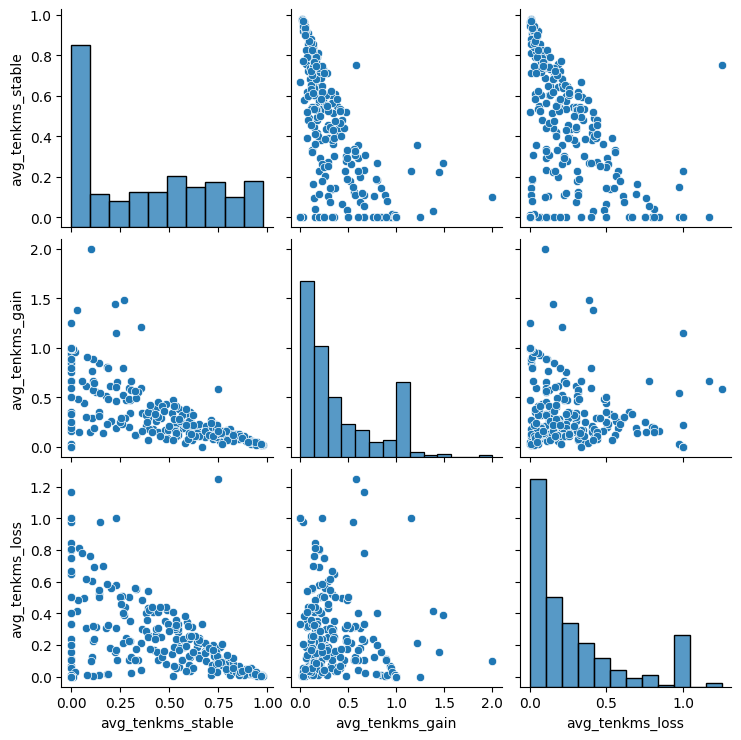

In [9]:
# Pairplot (useless?)
sample = sklearn.utils.resample(dist_means, n_samples=10)
ax = sns.pairplot(dist_means.query("interval == '1990-2010'")[["avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]])

### Readying labelled data for machine learning classifiers

In [10]:
cons_labels = conservation_status[["speccode", "status"]]
cons_labels = cons_labels[cons_labels["speccode"].isin(dist_means["speccode"])]
cons_labels

,speccode,status
0,1,g
1,2,a
2,3,a
5,6,g
6,7,g
...,...,...
448,1563,g
449,1569,g
452,1578,g
453,1579,g


#### Dataframe for machine learning

<table>
    <tr>
        <th>Column</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>speccode</td>
        <td>A unique number identifying a particular bird species.</td>
    </tr>
    <tr>
        <td>interval</td>
        <td>The period of time covered by the particular atlas.</td>
    </tr>
    <tr>
        <td colspan=3><strong>These columns represent averages over a 1-hot vector &#8212; that is, the proportion of 10km squares in which the species was detected or not at the beginning/end of the interval.</strong></td>
    </tr>
    <tr>
        <td>avg_tenkms_stable</td>
        <td>The proportion of 10km squares where the species was detected in at the beginning <strong>and</strong> end of the interval.</td>
    </tr>
    <tr>
        <td>avg_tenkms_gain</td>
        <td>The proportion of 10km squares where the species was detected at the end of the interval, but <strong>not</strong> the beginning.</td>
    </tr>
    <tr>
        <td>avg_tenkms_loss</td>
        <td>The proportion of 10km squares where the species was detected at the beginning of the interval, but <strong>not</strong> the end.</td>
    </tr>
    <tr>
        <td>status</td>
        <td>The conservation status of the species &#8212; Green, Amber, Red or Black (former breeding birds)</td>
    </tr>
</table>

In [11]:
dist_means_labelled = dist_means.merge(right=cons_labels, on="speccode")
dist_means_labelled

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
0,1,1970-1990,0.63,0.27,0.10,g
1,1,1990-2010,0.60,0.16,0.24,g
2,2,1970-1990,0.51,0.22,0.26,a
3,2,1990-2010,0.54,0.26,0.20,a
4,3,1970-1990,0.02,0.87,0.11,a
...,...,...,...,...,...,...
583,1563,1970-1990,0.00,0.00,1.00,g
584,1569,1970-1990,0.00,0.00,1.00,g
585,1578,1970-1990,0.00,0.00,1.00,g
586,1579,1970-1990,0.00,0.00,1.00,g


In [12]:
# Data on a few birds from the Red list
display(Markdown("Greenfinch ( *Cloris cloris* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 470]) # greenfinch
display(Markdown("House sparrow ( *Passer domesticus* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 459]) # house sparrow
display(Markdown("Tree sparrow ( *Passer montanus* )"))
display(dist_means_labelled[dist_means_labelled["speccode"] == 461]) # tree sparrow

Greenfinch ( *Cloris cloris* )

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
503,470,1970-1990,0.89,0.03,0.08,r
504,470,1990-2010,0.88,0.11,0.01,r


House sparrow ( *Passer domesticus* )

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
493,459,1970-1990,0.93,0.00,0.06,r
494,459,1990-2010,0.93,0.05,0.02,r


Tree sparrow ( *Passer montanus* )

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
495,461,1970-1990,0.66,0.09,0.25,r
496,461,1990-2010,0.53,0.16,0.31,r


### Quick auto-assessment of various machine learning techniques
This automatic overview of various machine learning techniques on the individual values of avg_tenkms_stable, avg_tenkms_gain and avg_tenkms_loss, and 

In [13]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_loss"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
display(models)

100%|██████████| 29/29 [00:00<00:00, 45.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.140576
[LightGBM] [Info] Start training from score -3.779634
[LightGBM] [Info] Start training from score -0.773951
[LightGBM] [Info] Start training from score -1.627872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.47,0.54,None,0.48,0.04
BaggingClassifier,0.55,0.39,None,0.55,0.02
ExtraTreesClassifier,0.55,0.39,None,0.56,0.08
DecisionTreeClassifier,0.54,0.38,None,0.55,0.01
LGBMClassifier,0.54,0.37,None,0.53,0.05
RandomForestClassifier,0.52,0.37,None,0.53,0.10
KNeighborsClassifier,0.49,0.36,None,0.50,0.02
SVC,0.53,0.35,None,0.51,0.01
LabelSpreading,0.53,0.35,None,0.51,0.01


In [14]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_gain"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 53.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.169564
[LightGBM] [Info] Start training from score -3.779634
[LightGBM] [Info] Start training from score -0.804104
[LightGBM] [Info] Start training from score -1.517871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.56,0.41,None,0.53,0.01
LabelSpreading,0.54,0.40,None,0.51,0.01
LGBMClassifier,0.54,0.39,None,0.55,0.05
AdaBoostClassifier,0.49,0.39,None,0.47,0.08
NearestCentroid,0.44,0.36,None,0.40,0.01
SGDClassifier,0.44,0.36,None,0.38,0.01
BaggingClassifier,0.50,0.33,None,0.48,0.02
RandomForestClassifier,0.48,0.32,None,0.47,0.10
Perceptron,0.41,0.32,None,0.43,0.01


In [15]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_stable"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 49.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.214684
[LightGBM] [Info] Start training from score -3.597312
[LightGBM] [Info] Start training from score -0.716243
[LightGBM] [Info] Start training from score -1.675500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.47,0.41,None,0.38,0.01
LabelPropagation,0.45,0.40,None,0.37,0.01
AdaBoostClassifier,0.40,0.40,None,0.35,0.07
LabelSpreading,0.44,0.39,None,0.36,0.01
LGBMClassifier,0.43,0.39,None,0.40,0.04
BernoulliNB,0.40,0.39,None,0.34,0.01
ExtraTreeClassifier,0.39,0.37,None,0.38,0.01
KNeighborsClassifier,0.38,0.34,None,0.34,0.01
DummyClassifier,0.41,0.33,None,0.24,0.01


### Neural Network approach - the first try
#### Inputs & outputs
||Shape|Form|
|-|-|-|
|Input|(6,)|$(avg\_stable_{1970-1990}, avg\_gain_{1970-1990}, avg\_loss_{1970-1990}, avg\_stable_{1990-2010}, avg\_gain_{1990-2010}, avg\_loss_{1990-2010})$|
|Output|(4,)|$(P(red), P(amber), P(green), P(black))$|

#### Network architecture
<img src="images/nn_1_arch.svg?1" width="40%" height="40%"></img>

#### Data preprocessing

In [16]:
# Arranging data for neural network use
# TODO make dataset the insersection of bird types between them
dist_means_labelled_1970 = dist_means_labelled.query("interval == '1970-1990'")
dist_means_labelled_1990 = dist_means_labelled.query("interval == '1990-2010'")
dist_means_labelled_1970

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
0,1,1970-1990,0.63,0.27,0.10,g
2,2,1970-1990,0.51,0.22,0.26,a
4,3,1970-1990,0.02,0.87,0.11,a
6,6,1970-1990,0.55,0.16,0.28,g
8,7,1970-1990,0.61,0.25,0.14,g
...,...,...,...,...,...,...
581,1359,1970-1990,0.00,1.00,0.00,g
583,1563,1970-1990,0.00,0.00,1.00,g
584,1569,1970-1990,0.00,0.00,1.00,g
585,1578,1970-1990,0.00,0.00,1.00,g


In [17]:
# These dataframes only contain data about birds which appear in both atlases
dist_1970_intersection = dist_means_labelled_1970[
    dist_means_labelled_1970["speccode"].isin(dist_means_labelled_1990["speccode"])
][["speccode", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss", "status"]]
dist_1990_intersection = dist_means_labelled_1990[
    dist_means_labelled_1990["speccode"].isin(dist_means_labelled_1970["speccode"])
][["speccode", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss", "status"]]
dist_1990_intersection

,speccode,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
1,1,0.60,0.16,0.24,g
3,2,0.54,0.26,0.20,a
5,3,0.00,0.02,0.98,a
7,6,0.56,0.33,0.11,g
9,7,0.65,0.22,0.13,g
...,...,...,...,...,...
565,1215,0.00,0.60,0.40,g
571,1288,0.00,0.99,0.01,g
575,1293,0.00,0.89,0.11,g
577,1294,0.00,0.00,1.00,g


**There are 269 bird species that are covered in both atlases.**

In [18]:
X = np.array(
    [
        (
            dml_1970[1],
            dml_1970[2],
            dml_1970[3],
            dml_1990[1],
            dml_1990[2],
            dml_1990[3],
        )
        for (dml_1970, dml_1990) in zip(
            dist_1970_intersection.to_numpy(), dist_1990_intersection.to_numpy()
        )
    ]
)
X.shape

(269, 6)

In [19]:
y = np.array(
    [
        (
            1 if i[-1] == "g" else 0, # green
            1 if i[-1] == "a" else 0, # amber
            1 if i[-1] == "r" else 0, # red
            1 if i[-1] == "b" else 0, # black (former breeding)
        )
        for i in dist_1970_intersection.to_numpy()
    ]
)
y.shape

(269, 4)

#### Train & evaluate with conventional hyperparams

##### Training, fitting and predicting

In [73]:
# Hyperparameters
TRAIN_SIZE = 0.20
BATCH_SIZE = 20
EPOCHS = 250
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [74]:
# This data is stratified by default!
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

In [75]:
model = keras.Sequential(
    [
        layers.Dense(units=8, activation="relu", input_shape=(6,)),
        layers.Dense(units=8, activation="relu"),
        layers.Dense(units=4),
    ]
)

In [76]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=METRICS,
)

In [77]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/250


3/3 [==============================] - 1s 10ms/step - loss: 0.2417 - cross entropy: 1.4347 - Brier score: 0.2417 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 53.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5881 - prc: 0.2715
Epoch 2/250
3/3 [==============================] - 0s 6ms/step - loss: 0.2347 - cross entropy: 1.2292 - Brier score: 0.2347 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 53.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6074 - prc: 0.2790
Epoch 3/250
3/3 [==============================] - 0s 6ms/step - loss: 0.2276 - cross entropy: 1.1329 - Brier score: 0.2276 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 53.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6199 - prc: 0.2863
Epoch 4/250
3/3 [==============================] - 0s 6ms/step - loss: 0.2210 - cross entropy: 1.0447 - Brier score: 0.2210 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 -

##### Evaluation of results

Accuracy is not a suitable metric for this dataset as it's very imbalanced.

In [78]:
evaluation = model.evaluate(X, y, batch_size=BATCH_SIZE)

14/14 [==============================] - 0s 2ms/step - loss: 0.1633 - cross entropy: 0.6269 - Brier score: 0.1633 - tp: 117.0000 - fp: 89.0000 - tn: 718.0000 - fn: 152.0000 - accuracy: 0.7760 - precision: 0.5680 - recall: 0.4349 - auc: 0.7686 - prc: 0.5185


The model tends to have precision near 0.5 and recall near 0.07.

No insight has been learned from the dataset, at least with these hyperparameters.

7/7 [==============================] - 0s 1ms/step


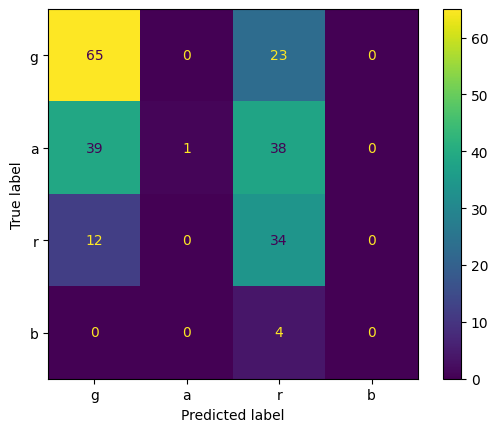

In [79]:
# Confusion matrix
y_predict = model.predict(X_test)
y_predict_max = np.array([
    np.argmax(i) for i in y_predict
])

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix
confusion = sklearn.metrics.confusion_matrix(y_test_labels, y_predict_max)
confusion_matrix = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=["g", "a", "r", "b"]).plot()

In [80]:
dist_1970_intersection["status"].value_counts()

status
g    108
a     88
r     68
b      5
Name: count, dtype: int64

Probably because most birds are on the green list, less are on the amber and even less on the red, and fortunately there are very few birds on the former breeding birds list.

#### Problems with this approach

- There's so many more birds in the Green list that the model just learns to guess green, and it'll be right half the time.
- The sample was stratified by default as `train_test_split` does $-$ there just wasn't enough birds in the dataset

### Does synthesising fictional bird species improve classification of real species?